In [303]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import palettable
import seaborn as sns
import matplotlib as mpl
import pickle
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss
import sdeint
import sympy as smp
from sympy import real_roots

In [11]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = 1 # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evaluate(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def getDistances(self):
        features = self.calDataNorm.iloc[:, 0:22]
        classes = self.calDataNorm['model']

        # Split the dataset into different classes
        class_data = defaultdict(list)
        for idx, row in df.iterrows():
            class_data[row['model']].append(row[:22].values)

        # Calculate pairwise distances within each class
        intra_class_distances = {}
        for class_label, feature_vectors in class_data.items():
            intra_class_distances[class_label] = pairwise_distances(feature_vectors)

        # Calculate pairwise distances between different classes
        inter_class_distances = defaultdict(dict)
        for class_label_1, feature_vectors_1 in class_data.items():
            for class_label_2, feature_vectors_2 in class_data.items():
                if class_label_1 != class_label_2:
                    inter_class_distances[class_label_1][class_label_2] = pairwise_distances(feature_vectors_1, feature_vectors_2)

        return intra_class_distances, inter_class_distances
        
    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [56]:
def gen_hopf_stoch(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:, 0]

def sample_hopf_stoch(eta_val_hopf, N_val_hopf, mu_val_hopf, seed=0):
    np.random.seed(seed=seed)
    regime_store = list()
    # hopf system
    lengths_store = list()
    sols_list = list()
    for i in range(len(eta_val_hopf)):
        # check regime
        if mu_val_hopf[i] > 0:
            regime_store.append('LimitCycle')
        else:
            regime_store.append('FixedPoint')
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_hopf_stoch(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths_store
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['system'] = 'Hopf'
    df['regime'] = regime_store

    return df, ts

In [57]:
def gen_hopf_deterministic(mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    sol = odeint(f, ic, tspan)
    return sol[500:, 0]

def sample_hopf_deterministic(N_val_hopf, mu_val_hopf, seed=0):
    np.random.seed(seed=seed)
    regime_store = list()
    # hopf system
    lengths_store = list()
    sols_list = list()
    eta_list = list()
    for i in range(len(N_val_hopf)):
        # check regime
        if mu_val_hopf[i] > 0:
            regime_store.append('LimitCycle')
        else:
            regime_store.append('FixedPoint')
        mu = mu_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_hopf_deterministic(mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)
        eta_list.append(0)

    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths_store
    df['mu'] = mu_val_hopf
    df['eta'] = eta_list
    df['system'] = 'Hopf'
    df['regime'] = regime_store

    return df, ts


In [58]:
def normalise(df, sig=True):
    rs = RobustScaler().fit(df.iloc[:,:22])
    rs_transformed = rs.transform(df.iloc[:,:22])
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
    if sig:
        sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.})
        sig_transformed = sig.transform(rs_transformed)
        mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = mm.transform(sig_transformed)
        xhat = mm_transformed
    else:
        mm = MinMaxScaler().fit(rs_transformed)
        mm_transformed = mm.transform(rs_transformed)
        xhat = mm_transformed
    return xhat


In [59]:
n_val_bif_diagram = np.tile(5000, 1000)
eta_val_stoch_bif_diagram = np.tile(0.2, 1000)
mu_val_bif_diagram = np.linspace(-5, 5, 1000)

In [60]:
df_stoch, ts_stoch = sample_hopf_stoch(eta_val_stoch_bif_diagram, n_val_bif_diagram, mu_val_bif_diagram)
df_clean, ts_clean = sample_hopf_deterministic(n_val_bif_diagram, mu_val_bif_diagram)

Compute bifurcation diagrams using min/max values as a proxy for amplitude 

In [61]:
points_stoch = list()
points_clean = list()
for index, mu in enumerate(mu_val_bif_diagram):
    points_clean.append((mu, np.max(ts_clean[index])))
    points_clean.append((mu, np.min(ts_clean[index])))
    points_stoch.append((mu, np.max(ts_stoch[index])))
    points_stoch.append((mu, np.min(ts_stoch[index])))

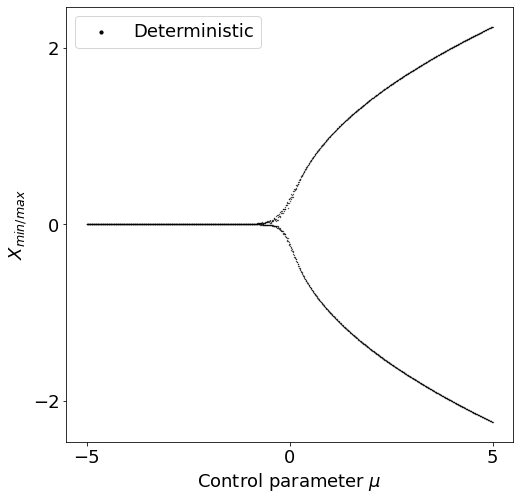

In [62]:
mu2, x2 = zip(*points_clean)
#mu1, x1 = zip(*points_stoch)
plt.figure(figsize=(8, 8))
plt.scatter(mu2, x2, s=0.1, c='k', alpha=1, label='Deterministic')
#plt.scatter(mu1,x1, s=0.5, c='steelblue', alpha=1, label='Stochastic')
plt.xlabel('Control parameter $\mu$', fontsize=18)
plt.xticks([-5, 0, 5], fontsize=18)
plt.ylabel('$X_{min/max}$', fontsize=18)
plt.yticks([-2, 0, 2], fontsize=18)
plt.legend(fontsize=18, markerscale=10)

Stochastic bifurcation with underlying deterministic bifurcation superimposed.

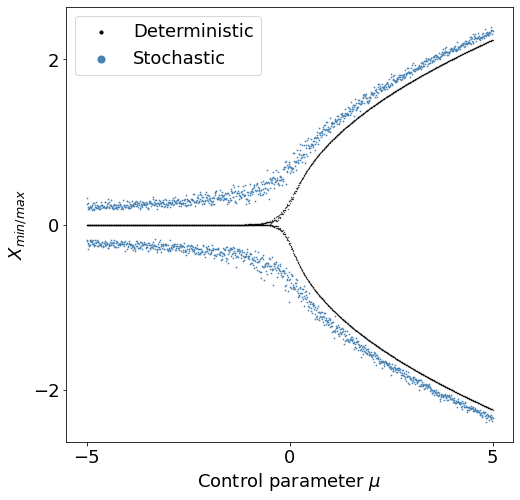

In [64]:
mu2, x2 = zip(*points_clean)
mu1, x1 = zip(*points_stoch)
plt.figure(figsize=(8, 8))
plt.scatter(mu2, x2, s=0.1, c='k', alpha=1, label='Deterministic')
plt.scatter(mu1,x1, s=0.5, c='steelblue', alpha=1, label='Stochastic')
plt.xlabel('Control parameter $\mu$', fontsize=18)
plt.xticks([-5, 0, 5], fontsize=18)
plt.ylabel('$X_{min/max}$', fontsize=18)
plt.yticks([-2, 0, 2], fontsize=18)
plt.legend(fontsize=18, markerscale=10)

## Feature Space Example

Case 1: Low Noise (0.2), Fixed Length (5000)

In [152]:
n_val_stoch_featurespace = np.tile(5000, 1000)
eta_val_stoch_featurespace = np.tile(0.2, 1000)
mu_val_stoch_featurespace = np.random.uniform(low=-5, high=5, size=1000)

In [153]:
df_stoch_feature, ts_stoch_feature = sample_hopf_stoch(eta_val_stoch_featurespace, n_val_stoch_featurespace, mu_val_stoch_featurespace)

In [156]:
xhat_stoch = normalise(df_stoch_feature)

In [157]:
pca = PCA(n_components=2).fit(xhat_stoch)
embedding = pca.transform(xhat_stoch)

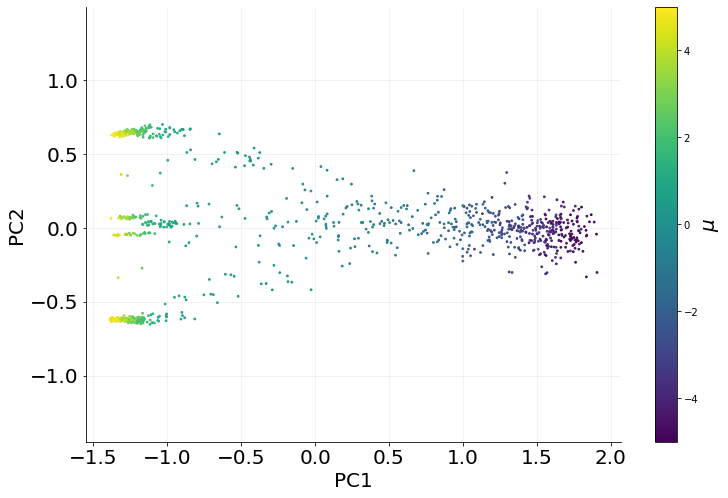

In [158]:
plt.figure(figsize=(12,8))
plt.scatter(embedding[:,0], embedding[:,1], c=df_stoch_feature['mu'], cmap='viridis', s=3)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

Case 2: High Noise (0.8), Fixed Length (5000)

In [178]:
n_val_stoch_featurespace2 = np.tile(5000, 1000)
eta_val_stoch_featurespace2 = np.tile(0.8, 1000)
mu_val_stoch_featurespace2 = np.random.uniform(low=-5, high=5, size=1000)

In [179]:
df_stoch_feature2, ts_stoch_feature2 = sample_hopf_stoch(eta_val_stoch_featurespace2, n_val_stoch_featurespace2, mu_val_stoch_featurespace2)

In [183]:
xhat_stoch2 = normalise(df_stoch_feature2, sig=False)

In [184]:
pca2 = PCA(n_components=2).fit(xhat_stoch2)
embedding2 = pca2.transform(xhat_stoch2)

In [192]:
import matplotlib.colors as colors


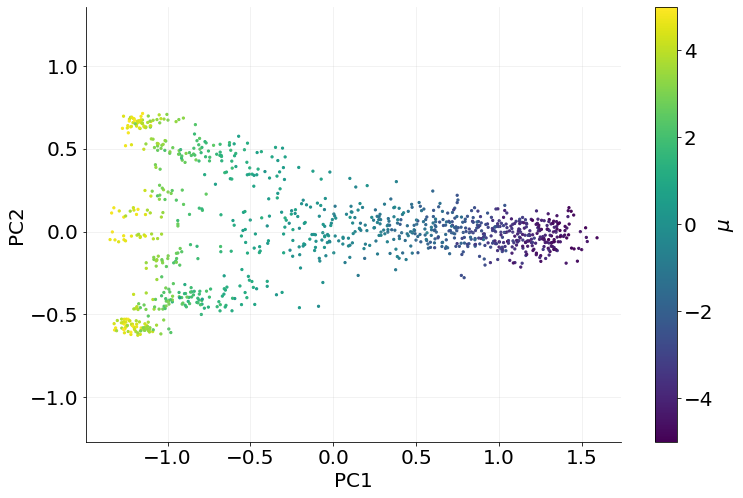

In [255]:
# Create a colormap instance
cmap = plt.get_cmap('viridis')

# Create a normalization instance
norm = colors.Normalize(vmin=-5, vmax=5)

# Scatter plot
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding2[:,0], embedding2[:,1], c=df_stoch_feature2['mu'], cmap=cmap, norm=norm, s=5)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create colorbar
cb = plt.colorbar(scatter)
cb.set_label('$\mu$', fontsize=20)
cb.ax.tick_params(labelsize=20)

#plt.savefig('hopf_featurespace_eta08.png', dpi=300, bbox_inches='tight')

In [222]:
df_stoch_feature2.iloc[975]['mu']

-2.1854220127532162

In [221]:
df_stoch_feature2[df_stoch_feature2['mu'] < -2.1]

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,N,mu,eta,system,regime
0,0.396259,0.064247,20.743445,87.0,0.506349,0.001310,0.891578,143.0,0.006592,177.0,...,1.612565,0.469388,0.346939,0.045252,0.368230,5000,-4.619620,0.8,Hopf,FixedPoint
3,0.216579,-0.113527,27.678132,70.0,0.597020,0.000273,0.870174,186.0,0.009365,85.0,...,1.535748,0.428571,0.367347,0.036816,0.298777,5000,-3.328629,0.8,Hopf,FixedPoint
6,-0.193237,0.150833,30.396297,99.0,0.554583,-0.000394,0.873375,165.0,0.001296,274.0,...,1.539265,0.551020,0.489796,0.029913,0.303569,5000,-2.383987,0.8,Hopf,FixedPoint
8,-0.193360,0.146812,21.924457,51.0,0.511765,-0.000130,0.888778,148.0,0.004931,112.0,...,1.595239,0.387755,0.489796,0.043718,0.345609,5000,-3.624618,0.8,Hopf,FixedPoint
10,0.103525,-0.215844,18.854807,71.0,0.504492,-0.000860,0.895379,159.0,0.001858,255.0,...,1.620722,0.510204,0.408163,0.050621,0.382664,5000,-4.207830,0.8,Hopf,FixedPoint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,0.162141,-0.197809,36.371854,87.0,0.579572,-0.000160,0.863373,164.0,0.002155,284.0,...,1.510229,0.530612,0.448980,0.027612,0.281415,5000,-2.185422,0.8,Hopf,FixedPoint
978,0.058224,-0.269258,19.081321,71.0,0.481239,0.000752,0.904181,79.0,0.007753,222.0,...,1.640625,0.530612,0.469388,0.056757,0.397195,5000,-4.194068,0.8,Hopf,FixedPoint
989,0.247092,-0.086513,17.760408,76.0,0.443170,-0.000025,0.904381,98.0,0.004678,278.0,...,1.646466,0.653061,0.265306,0.052922,0.405598,5000,-4.952703,0.8,Hopf,FixedPoint
992,0.042680,-0.254771,36.871110,77.0,0.675456,0.000495,0.862573,160.0,0.004285,473.0,...,1.528339,0.489796,0.448980,0.027612,0.274776,5000,-2.570403,0.8,Hopf,FixedPoint


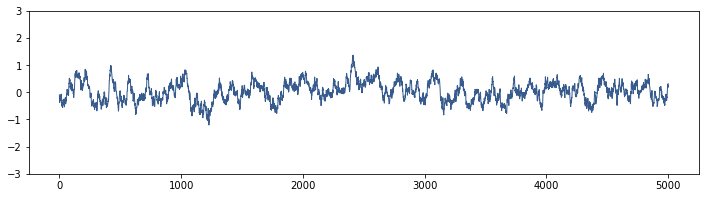

In [251]:
mu_value = df_stoch_feature2.iloc[975]['mu'] # your mu value here

# Get the color corresponding to the mu value
color = cmap(norm(mu_value))

# Time series plot
# Assume ts is your time series
plt.figure(figsize=(12,3))
plt.ylim(-3, 3)
plt.plot(ts_stoch_feature2[975], color=color, linewidth=1)
plt.savefig('hopf_timeseries_eta08_muN2.png', dpi=300, bbox_inches='tight')

In [227]:
df_stoch_feature2.iloc[55]['mu']

-4.387576360890771

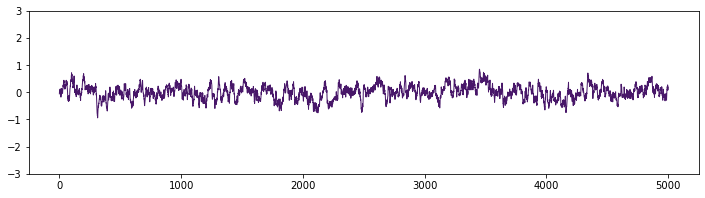

In [250]:
mu_value = df_stoch_feature2.iloc[55]['mu'] # your mu value here

# Get the color corresponding to the mu value
color = cmap(norm(mu_value))

# Time series plot
# Assume ts is your time series
plt.figure(figsize=(12,3))
plt.ylim(-3, 3)
plt.plot(ts_stoch_feature2[55], color=color, linewidth=1)
plt.savefig('hopf_timeseries_eta08_muN4.png', dpi=300, bbox_inches='tight')

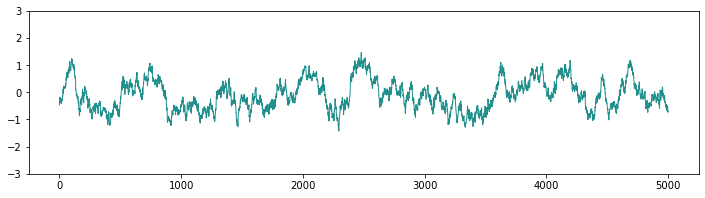

In [249]:
mu_value = df_stoch_feature2.iloc[337]['mu'] # your mu value here

# Get the color corresponding to the mu value
color = cmap(norm(mu_value))

# Time series plot
# Assume ts is your time series
plt.figure(figsize=(12,3))
plt.ylim(-3, 3)
plt.plot(ts_stoch_feature2[337], color=color, linewidth=1)
plt.savefig('hopf_timeseries_eta08_mu0.png', dpi=300, bbox_inches='tight')

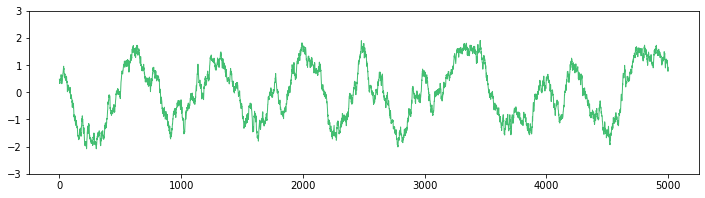

In [245]:
mu_value = df_stoch_feature2.iloc[999]['mu'] # your mu value here

# Get the color corresponding to the mu value
color = cmap(norm(mu_value))

# Time series plot
# Assume ts is your time series
plt.figure(figsize=(12,3))
plt.ylim(-3, 3)
plt.plot(ts_stoch_feature2[999], color=color, linewidth=1)
plt.savefig('hopf_timeseries_eta08_muP2.png', dpi=300, bbox_inches='tight')

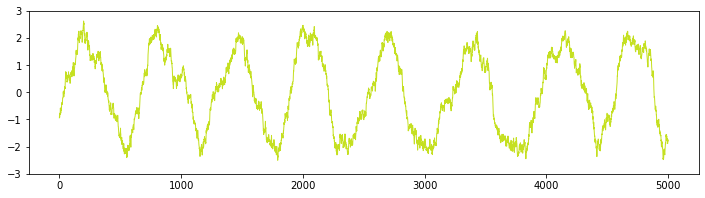

In [248]:
mu_value = df_stoch_feature2.iloc[9]['mu'] # your mu value here

# Get the color corresponding to the mu value
color = cmap(norm(mu_value))

# Time series plot
# Assume ts is your time series
plt.figure(figsize=(12,3))
plt.ylim(-3, 3)
plt.plot(ts_stoch_feature2[9], color=color, linewidth=1)
plt.savefig('hopf_timeseries_eta08_muP4.png', dpi=300, bbox_inches='tight')

Case 3: High Noise (0.8), 

In [134]:
n_val_stoch_featurespace3 = np.tile(100, 1000)
eta_val_stoch_featurespace3 = np.tile(0.8, 1000)
mu_val_stoch_featurespace3 = np.random.uniform(low=-5, high=5, size=1000)

In [135]:
df_stoch_feature3, ts_stoch_feature3 = sample_hopf_stoch(eta_val_stoch_featurespace3, n_val_stoch_featurespace3, mu_val_stoch_featurespace3)


In [136]:
xhat_stoch3 = normalise(df_stoch_feature3)

In [137]:
pca3 = PCA(n_components=2).fit(xhat_stoch3)
embedding3 = pca3.transform(xhat_stoch3)

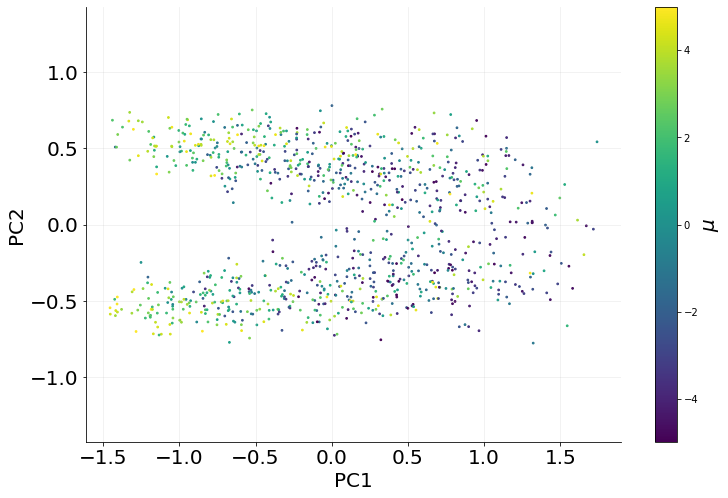

In [138]:
plt.figure(figsize=(12,8))
plt.scatter(embedding3[:,0], embedding3[:,1], c=df_stoch_feature3['mu'], cmap='viridis', s=3)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cb = plt.colorbar().set_label('$\mu$', fontsize=20)

In [139]:
n_val_stoch_featurespace3 = np.random.randint(low=50, high=5000, size=1000)
eta_val_stoch_featurespace3 = np.random.uniform(low=0, high=1, size=1000)
mu_val_stoch_featurespace3 = np.random.uniform(low=-5, high=5, size=1000)

In [140]:
df_stoch_feature3, ts_stoch_feature3 = sample_hopf_stoch(eta_val_stoch_featurespace3, n_val_stoch_featurespace3, mu_val_stoch_featurespace3)

In [141]:
xhat_stoch3 = normalise(df_stoch_feature3)

In [142]:
pca3 = PCA(n_components=2).fit(xhat_stoch3)
embedding3 = pca3.transform(xhat_stoch3)

## Three system case study

In [632]:
def gen_hopf(num_samples, seed=0): # num samples
    np.random.seed(seed)
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    lengths = list()
    regime = list()
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        if mu > 0:
            regime.append('Hopf Limit Cycle')
        else:
            regime.append('Hopf Fixed Point')
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = regime
    return ts_hopf, df

In [399]:
ts_hopf, df_hopf = gen_hopf(1000)

In [400]:
def gen_hookes(num_samples, seed=34):
    np.random.seed(seed)
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-5, -0.1, size=num_samples)
    sols_list = list()
    dt = 0.01
    lengths = list()
    tspan = np.arange(0, 55, dt)
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'Hookes Fixed Point'
    
    return ts_hookes, df_hookes

In [401]:
ts_hookes, df_hookes = gen_hookes(1000)

In [402]:
def gen_bistable(num_samples, seed=85):
    np.random.seed(seed)
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    lengths = list()
    regime_list = list()
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            regime_list.append('Bistable Switching')
        else:
            regime_list.append('Bistable Fixed Point')

    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = lengths
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = regime_list
    return ts_bistable, df_bistable


In [652]:
ts_bistable, df_bistable = gen_bistable(1000)

In [427]:
ts_all = np.concatenate((ts_hopf, ts_hookes, ts_bistable), axis=0)

In [404]:
df_combined = pd.concat([df_hopf, df_hookes, df_bistable], ignore_index=True)

In [408]:
rs = RobustScaler().fit(df_combined.iloc[:,:22])
rs_fit = rs.transform(df_combined.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)

In [409]:
pca_toy_example = PCA(n_components=2).fit(mm_fit)
toy_example_embeddings = pca_toy_example.transform(mm_fit)

In [422]:
pca_df = pd.DataFrame(toy_example_embeddings, columns=['PC1', 'PC2'])
pca_df['regime'] = df_combined['regime']
pca_df['N'] = df_combined['N']
pca_df['mu'] = df_combined['mu']
pca_df['eta'] = df_combined['eta']


In [445]:
plt.style.use('default')

labelled by regime

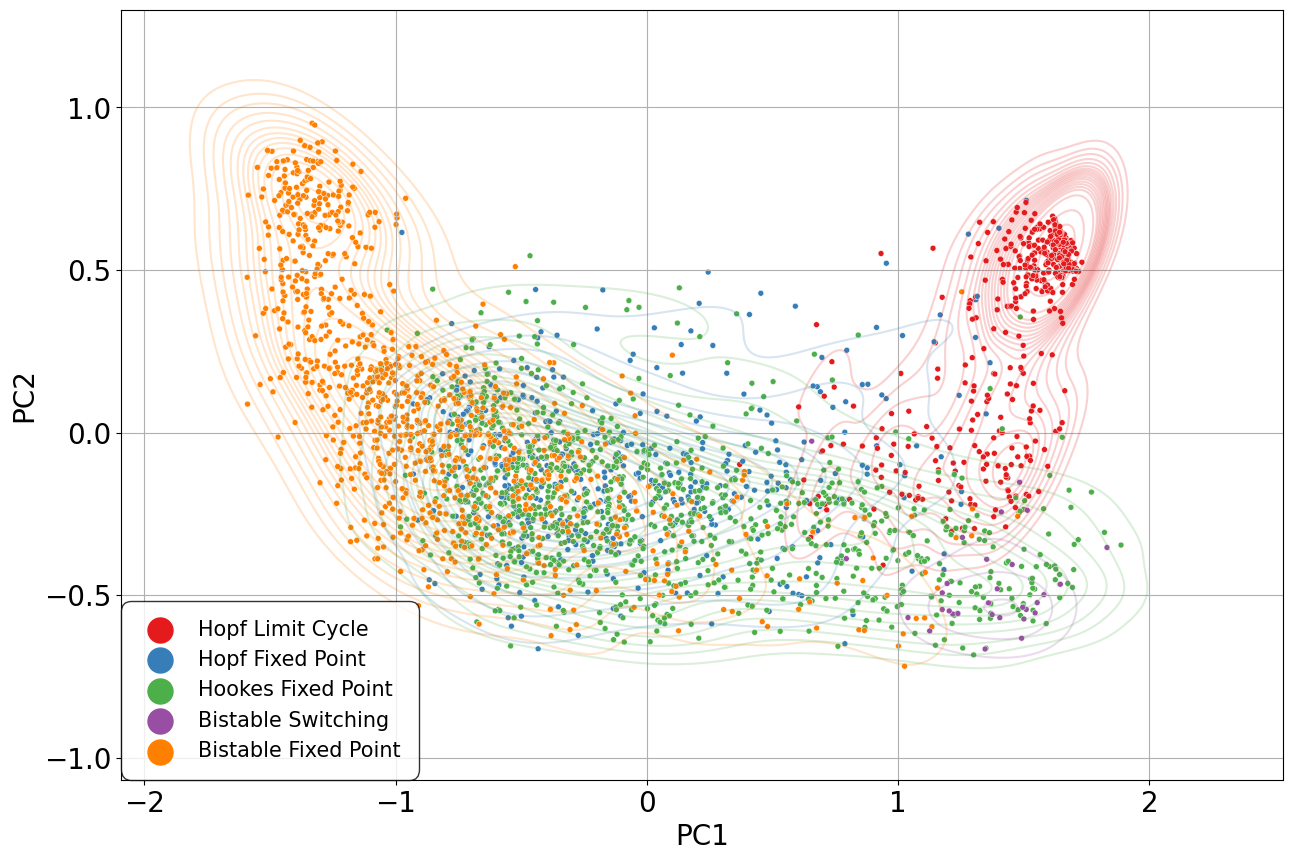

In [449]:
plt.figure(figsize=(15, 10))
sns.kdeplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df_combined['regime'], alpha=0.2, palette='Set1', levels=20)
sns.scatterplot(x=toy_example_embeddings[:,0], y=toy_example_embeddings[:,1], hue=df_combined['regime'], s=18, palette='Set1')
plt.grid()

legend = plt.legend(fontsize=15, frameon=True, loc='lower left', markerscale=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_boxstyle('round,pad=0.5')

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('toy_space.png', dpi=600)
plt.show()

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
         1.25]),
 <a list of 10 Text major ticklabel objects>)

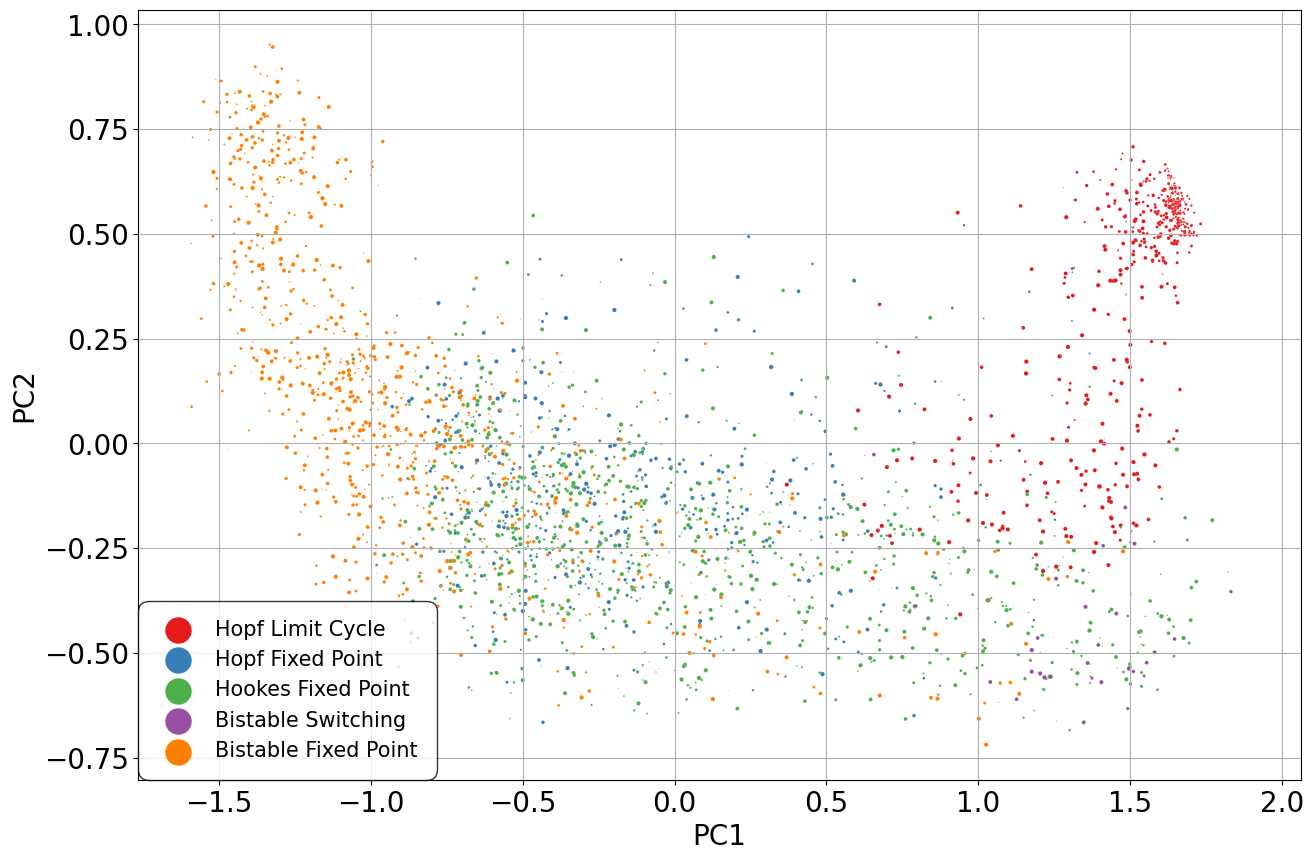

In [465]:
plt.figure(figsize=(15, 10))
#sns.kdeplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df_combined['eta'], alpha=0.2, palette='Set1', levels=20)
sns.scatterplot(x=toy_example_embeddings[:,0], y=toy_example_embeddings[:,1], hue=df_combined['regime'], s=df_combined['eta']*10, palette='Set1')
plt.grid()

legend = plt.legend(fontsize=15, frameon=True, loc='lower left', markerscale=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_boxstyle('round,pad=0.5')

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

Sample time series

1. Bistable switching

In [432]:
df_combined['regime'].value_counts()

Hookes Fixed Point      1000
Bistable Fixed Point     970
Hopf Limit Cycle         519
Hopf Fixed Point         481
Bistable Switching        30
Name: regime, dtype: int64

In [435]:
df_combined[df_combined['regime'] == 'Bistable Switching'].index

Int64Index([2000, 2055, 2203, 2227, 2241, 2250, 2282, 2336, 2347, 2371, 2377,
            2383, 2389, 2406, 2414, 2424, 2426, 2479, 2508, 2563, 2650, 2678,
            2713, 2720, 2757, 2874, 2901, 2921, 2925, 2971],
           dtype='int64')

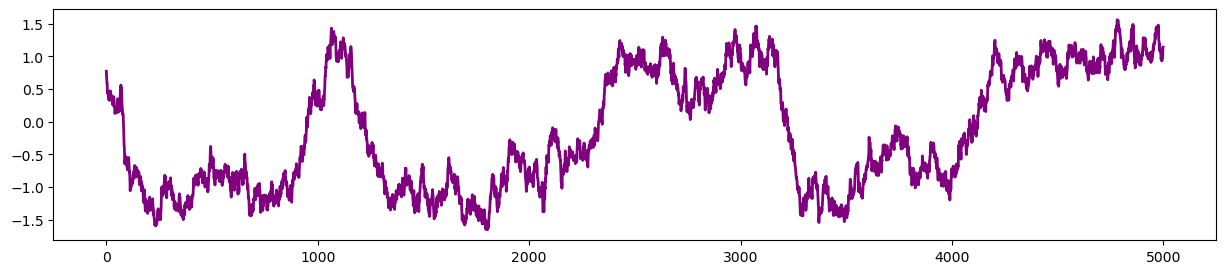

In [451]:
plt.figure(figsize=(15,3))
plt.plot(ts_all[2000], linewidth=2, color='purple')
plt.savefig('switching_ts.png', dpi=300, transparent=True)

2. Bistable fixed point

In [452]:
df_combined[df_combined['regime'] == 'Bistable Fixed Point'].index

Int64Index([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            ...
            2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999],
           dtype='int64', length=970)

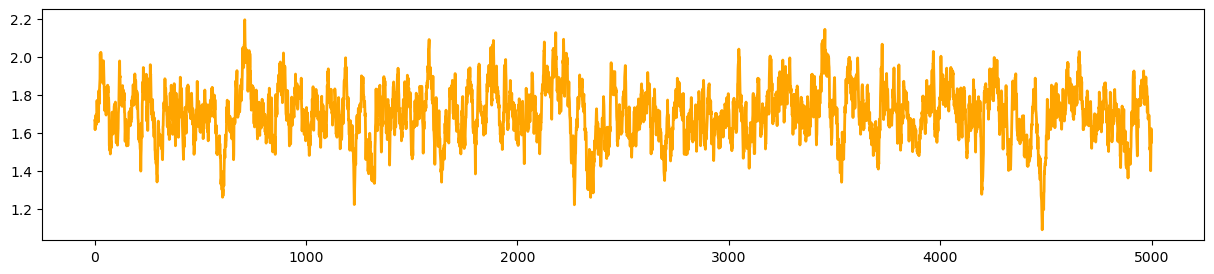

In [455]:
plt.figure(figsize=(15,3))
plt.plot(ts_all[2001], linewidth=2, color='orange')
plt.savefig('bistable_fp_ts.png', dpi=300, transparent=True)

3. Hopf Limit Cycle

In [456]:
df_combined[df_combined['regime'] == 'Hopf Limit Cycle'].index

Int64Index([  0,   3,   5,   6,   9,  10,  18,  19,  21,  22,
            ...
            983, 984, 988, 989, 991, 993, 995, 996, 998, 999],
           dtype='int64', length=519)

In [466]:
pca_df.iloc[3]

PC1               1.437861
PC2               0.517282
regime    Hopf Limit Cycle
N                     5000
mu                2.087704
eta               0.549434
Name: 3, dtype: object

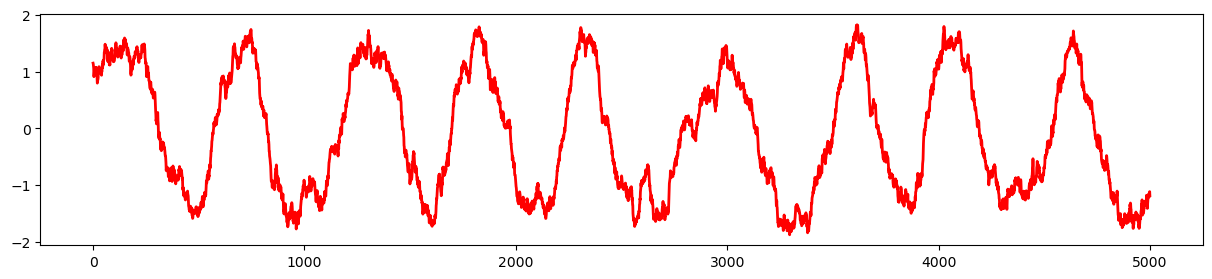

In [468]:
plt.figure(figsize=(15,3))
plt.plot(ts_all[3], linewidth=2, color='red')
plt.savefig('hopf_lc_ts.png', dpi=300, transparent=True)

Hookes FP

In [469]:
df_combined[df_combined['regime'] == 'Hookes Fixed Point'].index

Int64Index([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
            ...
            1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
           dtype='int64', length=1000)

In [470]:
pca_df.iloc[1000]

PC1                -0.686716
PC2                -0.238307
regime    Hookes Fixed Point
N                       5000
mu                 -4.225828
eta                 0.048176
Name: 1000, dtype: object

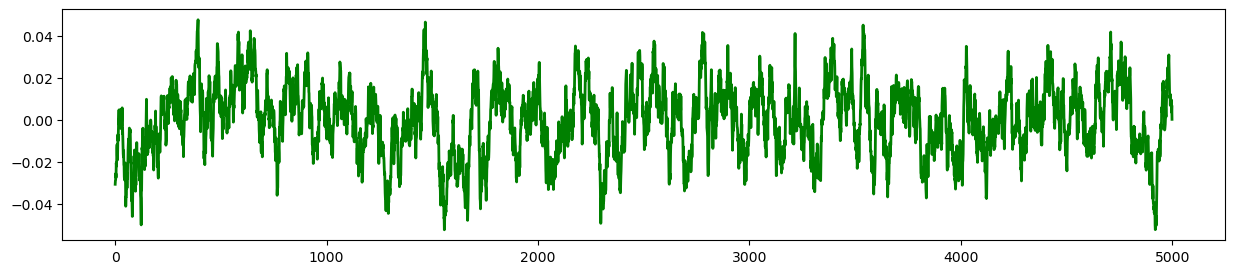

In [479]:
plt.figure(figsize=(15,3))
plt.plot(ts_all[1000], linewidth=2, color='green')
plt.savefig('hookes_fp_ts.png', dpi=300, transparent=True)

Hopf FP

In [480]:
df_combined[df_combined['regime'] == 'Hopf Fixed Point'].index

Int64Index([  1,   2,   4,   7,   8,  11,  12,  13,  14,  15,
            ...
            976, 979, 982, 985, 986, 987, 990, 992, 994, 997],
           dtype='int64', length=481)

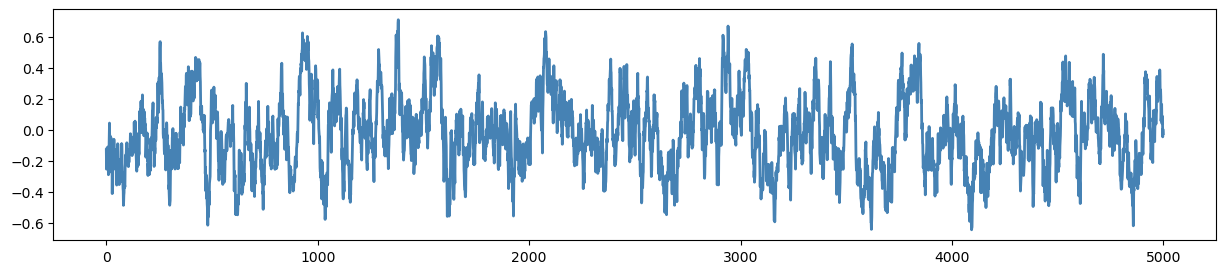

In [485]:
plt.figure(figsize=(15,3))
plt.plot(ts_all[1], linewidth=2, color='steelblue')
plt.savefig('hopf_fp_ts.png', dpi=300, transparent=True)

In [502]:
from sklearn.metrics import pairwise_distances

Compute pairwise distributions using the standardised feature scales.

In [499]:
mm_combined = pd.DataFrame(mm_fit)
mm_combined['N'] = df_combined['N']
mm_combined['mu'] = df_combined['mu']
mm_combined['eta'] = df_combined['eta']
mm_combined['regime'] = df_combined['regime']


In [503]:
mm_combined['regime'].value_counts()

Hookes Fixed Point      1000
Bistable Fixed Point     970
Hopf Limit Cycle         519
Hopf Fixed Point         481
Bistable Switching        30
Name: regime, dtype: int64

In [508]:
mm_combined[mm_combined['regime'] == 'Bistable Switching']['eta']

2000    0.624170
2055    0.701886
2203    0.642550
2227    0.839743
2241    0.893932
2250    0.766690
2282    0.678584
2336    0.835240
2347    0.997245
2371    0.734184
2377    0.480253
2383    0.886671
2389    0.631128
2406    0.800893
2414    0.548669
2424    0.728563
2426    0.910915
2479    0.748802
2508    0.764835
2563    0.846088
2650    0.705748
2678    0.716189
2713    0.789262
2720    0.427930
2757    0.813855
2874    0.965756
2901    0.934510
2921    0.950967
2925    0.948759
2971    0.915736
Name: eta, dtype: float64

In [621]:
mm_hopf_limit_cycle = mm_combined[mm_combined['regime'] == 'Hopf Limit Cycle'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_hopf_fixed_point = mm_combined[mm_combined['regime'] == 'Hopf Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_bistable_fixedpoint = mm_combined[mm_combined['regime'] == 'Bistable Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_bistable_switching = mm_combined[mm_combined['regime'] == 'Bistable Switching'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_hookes_fixed_point = mm_combined[mm_combined['regime'] == 'Hookes Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})

within class distances

In [622]:
dist_within_hopf_lc = pairwise_distances(mm_hopf_limit_cycle, metric='euclidean')
dist_within_hopf_fp = pairwise_distances(mm_hopf_fixed_point, metric='euclidean')
dist_within_bistable_fp = pairwise_distances(mm_bistable_fixedpoint, metric='euclidean')
dist_within_bistable_sw = pairwise_distances(mm_bistable_switching, metric='euclidean')
dist_within_hookes_fp = pairwise_distances(mm_hookes_fixed_point, metric='euclidean')

In [623]:
i_upper = np.triu_indices(dist_within_hopf_lc.shape[0], k=1)
dist_within_hopf_lc = dist_within_hopf_lc[i_upper].flatten()

i_upper = np.triu_indices(dist_within_hopf_fp.shape[0], k=1)
dist_within_hopf_fp = dist_within_hopf_fp[i_upper].flatten()

i_upper = np.triu_indices(dist_within_bistable_fp.shape[0], k=1)
dist_within_bistable_fp = dist_within_bistable_fp[i_upper].flatten()

i_upper = np.triu_indices(dist_within_bistable_sw.shape[0], k=1)
dist_within_bistable_sw = dist_within_bistable_sw[i_upper].flatten()

i_upper = np.triu_indices(dist_within_hookes_fp.shape[0], k=1)
dist_within_hookes_fp = dist_within_hookes_fp[i_upper].flatten()

between class distances

In [624]:
hopf_lc_to_hopf_fp = pairwise_distances(mm_hopf_limit_cycle, mm_hopf_fixed_point, metric='euclidean').flatten()
hopf_lc_to_bistable_sw = pairwise_distances(mm_hopf_limit_cycle, mm_bistable_switching, metric='euclidean').flatten()
hopf_lc_to_bistable_fp = pairwise_distances(mm_hopf_limit_cycle, mm_bistable_fixedpoint, metric='euclidean').flatten()
hopf_lc_to_hookes_fp = pairwise_distances(mm_hopf_limit_cycle, mm_hookes_fixed_point, metric='euclidean').flatten()
hopf_fp_to_hookes_fp = pairwise_distances(mm_hopf_fixed_point, mm_hookes_fixed_point, metric='euclidean').flatten()
hopf_fp_to_bistable_fp = pairwise_distances(mm_hopf_fixed_point, mm_bistable_fixedpoint, metric='euclidean').flatten()
hookes_fp_to_bistable_fp = pairwise_distances(mm_hookes_fixed_point, mm_bistable_fixedpoint, metric='euclidean').flatten()
bistable_fp_to_bistable_sw = pairwise_distances(mm_bistable_fixedpoint, mm_bistable_switching, metric='euclidean').flatten()

Generate a violin plot to illustrate the pairwise distance distributions

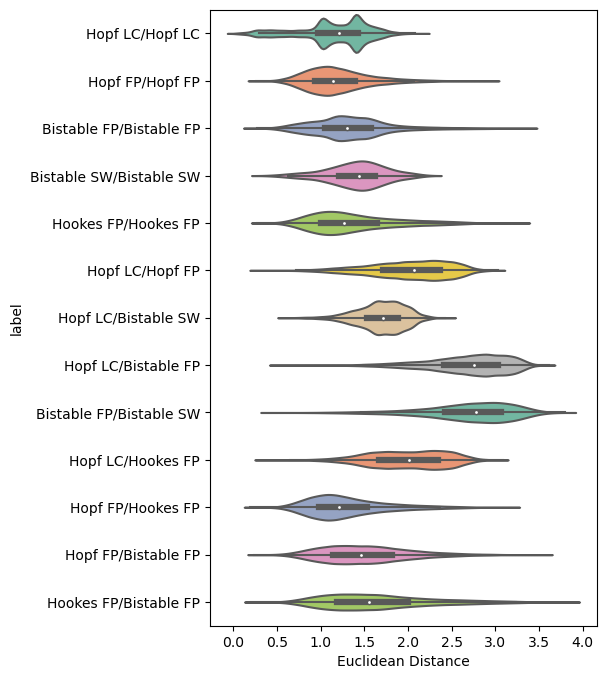

In [629]:
df_pairwise_dists = pd.DataFrame({
    'distance': np.concatenate([
        dist_within_hopf_lc,
        dist_within_hopf_fp,
        dist_within_bistable_fp,
        dist_within_bistable_sw,
        dist_within_hookes_fp,
        hopf_lc_to_hopf_fp,
        hopf_lc_to_bistable_sw,
        hopf_lc_to_bistable_fp,
        bistable_fp_to_bistable_sw,
        hopf_lc_to_hookes_fp,
        hopf_fp_to_hookes_fp,
        hopf_fp_to_bistable_fp,
        hookes_fp_to_bistable_fp,

    ]),
    'label': np.repeat([
        'Hopf LC/Hopf LC',
        'Hopf FP/Hopf FP',
        'Bistable FP/Bistable FP',
        'Bistable SW/Bistable SW',
        'Hookes FP/Hookes FP',
        'Hopf LC/Hopf FP',
        'Hopf LC/Bistable SW',
        'Hopf LC/Bistable FP',
        'Bistable FP/Bistable SW',
        'Hopf LC/Hookes FP',
        'Hopf FP/Hookes FP',
        'Hopf FP/Bistable FP',
        'Hookes FP/Bistable FP',
    ], [
        len(dist_within_hopf_lc),
        len(dist_within_hopf_fp),
        len(dist_within_bistable_fp),
        len(dist_within_bistable_sw),
        len(dist_within_hookes_fp),
        len(hopf_lc_to_hopf_fp),
        len(hopf_lc_to_bistable_sw),
        len(hopf_lc_to_bistable_fp),
        len(bistable_fp_to_bistable_sw),
        len(hopf_lc_to_hookes_fp),
        len(hopf_fp_to_hookes_fp),
        len(hopf_fp_to_bistable_fp),
        len(hookes_fp_to_bistable_fp),
    ])
})

# Create the violin plot
plt.figure(figsize=(5, 8))
sns.violinplot(x='distance', y='label', data=df_pairwise_dists, palette='Set2')

plt.xticks(fontsize=10)  # Rotate the x-axis labels for better readability
plt.xlabel('Euclidean Distance')
#plt.savefig('figures/pairwise_distances.png', dpi=400, bbox_inches='tight', transparent=True)

#plt.show()


## Short and Noisy Case

In [641]:
def gen_hopf2(num_samples, seed=0): # num samples
    np.random.seed(seed)
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 6, dt)
    lengths = list()
    regime = list()
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        if mu > 0:
            regime.append('Hopf Limit Cycle')
        else:
            regime.append('Hopf Fixed Point')
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = regime
    return ts_hopf, df

In [642]:
ts_hopf_short, df_hopf_short = gen_hopf2(1000, seed=0)

In [648]:
def gen_hookes2(num_samples, seed=34):
    np.random.seed(seed)
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-5, -0.1, size=num_samples)
    sols_list = list()
    dt = 0.01
    lengths = list()
    tspan = np.arange(0, 6, dt)
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'Hookes Fixed Point'
    return ts_hookes, df_hookes

In [649]:
ts_hookes_short, df_hookes_short = gen_hookes2(1000, seed=34)

In [653]:
def gen_bistable2(num_samples, seed=85):
    np.random.seed(seed)
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.random.uniform(-5, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 6, dt)
    lengths = list()
    regime_list = list()
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            regime_list.append('Bistable Switching')
        else:
            regime_list.append('Bistable Fixed Point')

    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = lengths
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = regime_list
    return ts_bistable, df_bistable

In [654]:
ts_bistable_short, df_bistable_short = gen_bistable2(1000, seed=85)

In [670]:
ts_all_short = np.concatenate((ts_hopf_short, ts_hookes_short, ts_bistable_short), axis=0)
df_combined_short = pd.concat((df_hopf_short, df_hookes_short, df_bistable_short), ignore_index=True)

In [671]:
rs = RobustScaler().fit(df_combined_short.iloc[:,:22])
rs_fit = rs.transform(df_combined_short.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)

In [695]:
pca_toy_example_short = PCA(n_components=2).fit(mm_fit)
toy_example_embeddings_short = pca_toy_example_short.transform(mm_fit)
pca_df_short = pd.DataFrame(toy_example_embeddings_short, columns=['PC1', 'PC2'])


In [696]:
pca_df_short['regime'] = df_combined_short['regime']
pca_df_short['N'] = df_combined_short['N']
pca_df_short['mu'] = df_combined_short['mu']
pca_df_short['eta'] = df_combined_short['eta']

No bistable switching for short and noisy case

In [729]:
pca_df_short['regime'].value_counts()

Hookes Fixed Point      1000
Bistable Fixed Point    1000
Hopf Limit Cycle         519
Hopf Fixed Point         481
Name: regime, dtype: int64

Plot

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 7 Text major ticklabel objects>)

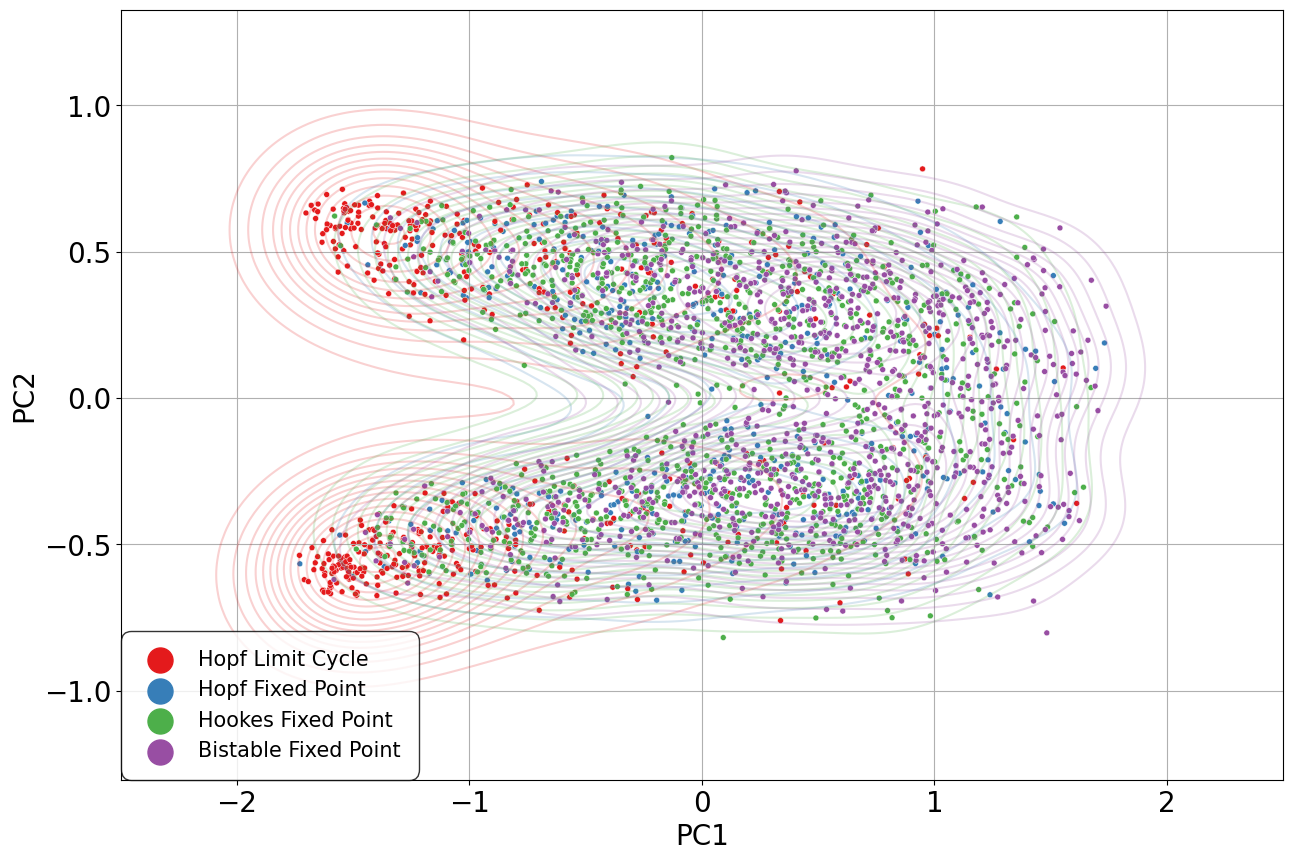

In [698]:
plt.figure(figsize=(15, 10))
sns.kdeplot(x=pca_df_short['PC1'], y=pca_df_short['PC2'], hue=pca_df_short['regime'], alpha=0.2, palette='Set1', levels=20)
sns.scatterplot(x=pca_df_short['PC1'], y=pca_df_short['PC2'], hue=pca_df_short['regime'], s=18, palette='Set1')
plt.grid()

legend = plt.legend(fontsize=15, frameon=True, loc='lower left', markerscale=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_boxstyle('round,pad=0.5')

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

PC2 loadings

In [706]:
pca_toy_example_short.components_[1].argmax()

13

### Example Time series

1. Noisy Limit Cycle

In [718]:
df_combined_short.iloc[999]

0                 0.432967
1                 0.276369
2                18.033162
3                     68.0
4                 0.899247
5                 0.001102
6                 0.787879
7                     63.0
8                 0.074074
9                      0.0
10                1.743748
11                    24.0
12                 0.03125
13                    0.64
14                   -0.72
15                0.964646
16                     5.0
17                 1.47747
18                0.828571
19                     0.6
20                0.049087
21                0.193677
N                      100
mu                0.017731
eta                0.68037
regime    Hopf Limit Cycle
Name: 999, dtype: object

In [719]:
pca_df_short.iloc[999]

PC1               -1.32992
PC2               0.588711
regime    Hopf Limit Cycle
N                      100
mu                0.017731
eta                0.68037
Name: 999, dtype: object

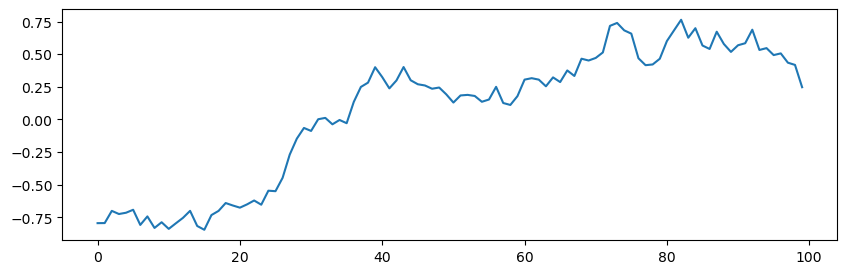

In [720]:
plt.figure(figsize=(10, 3))
plt.plot(ts_all_short[999])

2. Low Noise Limit Cycle

In [722]:
df_combined_short[df_combined_short['regime'] == 'Hopf Limit Cycle']

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,N,mu,eta,regime
0,0.587459,0.366572,6.329626,22.0,0.459005,-0.018307,0.919192,19.0,0.045267,18.0,...,7.0,1.581485,0.400000,0.228571,0.147262,0.497500,100,0.928803,0.553325,Hopf Limit Cycle
3,1.332670,-0.745107,20.968911,63.0,0.956036,-0.000817,0.747475,53.0,0.166667,31.0,...,14.0,1.499035,0.171429,0.742857,0.049087,0.113096,100,2.087704,0.549434,Hopf Limit Cycle
5,0.939132,0.565511,17.142123,53.0,0.794907,0.005591,0.858586,64.0,0.074074,22.0,...,5.0,1.534119,0.800000,0.600000,0.049087,0.251822,100,3.795215,0.649435,Hopf Limit Cycle
6,0.295109,0.478944,14.972980,33.0,0.770346,0.004513,0.797980,60.0,0.074074,0.0,...,8.0,1.562140,0.771429,0.742857,0.049087,0.247125,100,0.200814,0.443211,Hopf Limit Cycle
9,0.789117,0.948984,21.538131,66.0,0.832488,-0.002317,0.717172,63.0,0.074074,30.0,...,12.0,1.321633,0.828571,0.828571,0.049087,0.168563,100,4.536757,0.389607,Hopf Limit Cycle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,-1.096782,-0.876755,20.086003,40.0,0.648416,0.010918,0.878788,40.0,0.166667,16.0,...,6.0,1.572757,0.685714,0.800000,0.049087,0.366466,100,1.603386,0.511794,Hopf Limit Cycle
995,0.950827,0.784024,21.038866,70.0,1.275986,-0.000225,0.515152,58.0,0.166667,0.0,...,18.0,1.189142,0.771429,0.600000,0.049087,0.060872,100,2.912816,0.106700,Hopf Limit Cycle
996,1.023190,0.843805,20.597201,63.0,1.182812,0.000847,0.656566,55.0,0.166667,30.0,...,6.0,1.499035,0.828571,0.828571,0.049087,0.120447,100,2.211981,0.519773,Hopf Limit Cycle
998,0.927262,1.092049,22.479403,62.0,1.248047,-0.000234,0.606061,50.0,0.166667,0.0,...,12.0,1.296298,0.171429,0.742857,0.049087,0.102793,100,1.438640,0.236360,Hopf Limit Cycle


In [723]:
df_combined_short.iloc[995]

0                 0.950827
1                 0.784024
2                21.038866
3                     70.0
4                 1.275986
5                -0.000225
6                 0.515152
7                     58.0
8                 0.166667
9                      0.0
10                5.422901
11                    13.0
12                0.166667
13                   -0.63
14                    0.79
15                0.958376
16                    18.0
17                1.189142
18                0.771429
19                     0.6
20                0.049087
21                0.060872
N                      100
mu                2.912816
eta                 0.1067
regime    Hopf Limit Cycle
Name: 995, dtype: object

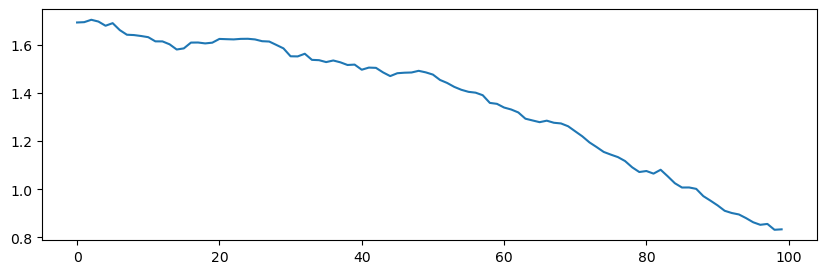

In [724]:
plt.figure(figsize=(10, 3))
plt.plot(ts_all_short[995])

In [725]:
mm_combined = pd.DataFrame(mm_fit)
mm_combined['N'] = df_combined_short['N']
mm_combined['mu'] = df_combined_short['mu']
mm_combined['eta'] = df_combined_short['eta']
mm_combined['regime'] = df_combined_short['regime']

In [757]:
mm_combined['regime'].value_counts()

Hookes Fixed Point      1000
Bistable Fixed Point    1000
Hopf Limit Cycle         519
Hopf Fixed Point         481
Name: regime, dtype: int64

no switching, so we must fill with groups for pairwise distances involving switching with NaNs to ensure colors and positions are consistent with other violin plor for the N = 5000 case.

In [726]:
mm_hopf_limit_cycle = mm_combined[mm_combined['regime'] == 'Hopf Limit Cycle'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_hopf_fixed_point = mm_combined[mm_combined['regime'] == 'Hopf Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_bistable_fixedpoint = mm_combined[mm_combined['regime'] == 'Bistable Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})
#mm_bistable_switching = mm_combined[mm_combined['regime'] == 'Bistable Switching'].drop(columns={'N', 'mu', 'eta', 'regime'})
mm_hookes_fixed_point = mm_combined[mm_combined['regime'] == 'Hookes Fixed Point'].drop(columns={'N', 'mu', 'eta', 'regime'})

within class distances

In [749]:
dist_within_hopf_lc = pairwise_distances(mm_hopf_limit_cycle, metric='euclidean')
dist_within_hopf_fp = pairwise_distances(mm_hopf_fixed_point, metric='euclidean')
dist_within_bistable_fp = pairwise_distances(mm_bistable_fixedpoint, metric='euclidean')
#dist_within_bistable_sw = pairwise_distances(mm_bistable_switching, metric='euclidean')
dist_within_hookes_fp = pairwise_distances(mm_hookes_fixed_point, metric='euclidean')

In [750]:
i_upper = np.triu_indices(dist_within_hopf_lc.shape[0], k=1)
dist_within_hopf_lc = dist_within_hopf_lc[i_upper].flatten()

i_upper = np.triu_indices(dist_within_hopf_fp.shape[0], k=1)
dist_within_hopf_fp = dist_within_hopf_fp[i_upper].flatten()

i_upper = np.triu_indices(dist_within_bistable_fp.shape[0], k=1)
dist_within_bistable_fp = dist_within_bistable_fp[i_upper].flatten()

#i_upper = np.triu_indices(dist_within_bistable_sw.shape[0], k=1)
#dist_within_bistable_sw = dist_within_bistable_sw[i_upper].flatten()

i_upper = np.triu_indices(dist_within_hookes_fp.shape[0], k=1)
dist_within_hookes_fp = dist_within_hookes_fp[i_upper].flatten()

between class distances

In [751]:
hopf_lc_to_hopf_fp = pairwise_distances(mm_hopf_limit_cycle, mm_hopf_fixed_point, metric='euclidean').flatten()
#hopf_lc_to_bistable_sw = pairwise_distances(mm_hopf_limit_cycle, mm_bistable_switching, metric='euclidean').flatten()
hopf_lc_to_bistable_fp = pairwise_distances(mm_hopf_limit_cycle, mm_bistable_fixedpoint, metric='euclidean').flatten()
hopf_lc_to_hookes_fp = pairwise_distances(mm_hopf_limit_cycle, mm_hookes_fixed_point, metric='euclidean').flatten()
hopf_fp_to_hookes_fp = pairwise_distances(mm_hopf_fixed_point, mm_hookes_fixed_point, metric='euclidean').flatten()
hopf_fp_to_bistable_fp = pairwise_distances(mm_hopf_fixed_point, mm_bistable_fixedpoint, metric='euclidean').flatten()
hookes_fp_to_bistable_fp = pairwise_distances(mm_hookes_fixed_point, mm_bistable_fixedpoint, metric='euclidean').flatten()
#bistable_fp_to_bistable_sw = pairwise_distances(mm_bistable_fixedpoint, mm_bistable_switching, metric='euclidean').flatten()


Generate a violin plot to illustrate the pairwise distance distributions

In [758]:
df_pairwise_dists = pd.DataFrame({
    'distance': np.concatenate([
        dist_within_hopf_lc,
        dist_within_hopf_fp,
        dist_within_bistable_fp,
        #dist_within_bistable_sw,
        [np.nan],
        dist_within_hookes_fp,
        hopf_lc_to_hopf_fp,
        #hopf_lc_to_bistable_sw,
        [np.nan],
        hopf_lc_to_bistable_fp,
        #bistable_fp_to_bistable_sw,
        [np.nan],
        hopf_lc_to_hookes_fp,
        hopf_fp_to_hookes_fp,
        hopf_fp_to_bistable_fp,
        hookes_fp_to_bistable_fp,

    ]),
    'label': np.repeat([
        'Hopf LC/Hopf LC',
        'Hopf FP/Hopf FP',
        'Bistable FP/Bistable FP',
        'Bistable SW/Bistable SW',
        'Hookes FP/Hookes FP',
        'Hopf LC/Hopf FP',
        'Hopf LC/Bistable SW',
        'Hopf LC/Bistable FP',
        'Bistable FP/Bistable SW',
        'Hopf LC/Hookes FP',
        'Hopf FP/Hookes FP',
        'Hopf FP/Bistable FP',
        'Hookes FP/Bistable FP',
    ], [
        len(dist_within_hopf_lc),
        len(dist_within_hopf_fp),
        len(dist_within_bistable_fp),
        1,
        len(dist_within_hookes_fp),
        len(hopf_lc_to_hopf_fp),
        1,
        len(hopf_lc_to_bistable_fp),
        1,
        len(hopf_lc_to_hookes_fp),
        len(hopf_fp_to_hookes_fp),
        len(hopf_fp_to_bistable_fp),
        len(hookes_fp_to_bistable_fp),
    ])
})

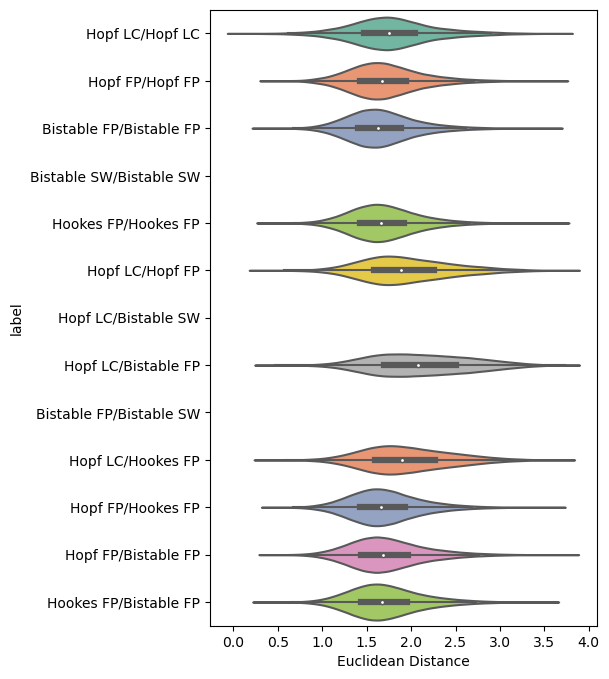

In [761]:
plt.figure(figsize=(5, 8))
sns.violinplot(x='distance', y='label', data=df_pairwise_dists, palette='Set2')

plt.xticks(fontsize=10)  # Rotate the x-axis labels for better readability
plt.xlabel('Euclidean Distance')
plt.savefig('pairwise_distances_short.png', dpi=400, bbox_inches='tight', transparent=True)
#plt.show()
